# data3a - Damage Severity

In [1]:
import urllib.request
import pickle
import matplotlib.pyplot as plt
from IPython.display import display,Image,clear_output
import numpy as np
import os
import h5py
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report,confusion_matrix
from collections import Counter,defaultdict

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Dropout, Activation, add
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.utils.np_utils import to_categorical
from keras.utils import get_file
from keras import optimizers
from keras.regularizers import l1, l2
from keras.callbacks import ModelCheckpoint, History

Using TensorFlow backend.
/home/akash/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from keras import backend as K
K.backend()

'tensorflow'

In [4]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('vgg16_weights.h5', WEIGHTS_PATH_NO_TOP)

### Defining input data

In [101]:
# path to the model weights file
location = './car-damage-dataset/data3a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
fine_tuned_model_path = './web-app/ft_model_severity_updated.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
val_data_dir = location+'/validation'

train_samples = [len(os.listdir(os.path.join(train_data_dir,i))) for i in os.listdir(train_data_dir)]
nb_train_samples = sum(train_samples)
val_samples = [len(os.listdir(os.path.join(val_data_dir,i))) for i in os.listdir(val_data_dir)]
nb_val_samples = sum(val_samples)

nb_epoch = 50

In [6]:
train_samples

[315, 278, 386]

In [7]:
K.image_data_format()

'channels_last'

In [8]:
if K.image_data_format() == 'channels_first':
    input_shape = (3,img_height,img_widthdth)
else:
    input_shape = (img_height,img_width,3)

In [9]:
input_shape

(256, 256, 3)

In [10]:
# def load_vgg16(weights_path='../vgg16_weights.h5'):
#     model = Sequential()
#     model.add(ZeroPadding2D(padding=(1,1),input_shape=(224,224,3)))   # for best performance you should set
#                                                                       # `image_data_format='channels_last'` 
#                                                                       # in your Keras config
#                                                                       # at ~/.keras/keras.json.
#     model.add(Convolution2D(filters=64, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=64, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=128, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=128, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     # assert os.path.exists(weights_path), 'Model weights not found (see "weights_path")'
    
#     # Use below code to freeze the conv model i.e. its learning
#     '''
#     for layer in model.layers:
#         layer.trainable = False
#     '''
    
#     if weights_path:
#     # note: this chops off the last layers of VGG16 

#     # loads the weights of the VGG16 networks
#     # NOTE: when there is a complete match between model definition
#     # and your weights savefile, you can simply call model.load_weights(filename)    
#         f = h5py.File(weights_path)
#         # LEFT CURRENTLY

In [11]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=input_shape ,pooling=max)

In [12]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [13]:
# Set base_model layers to non-trainable
for layer in base_model.layers:
    layer.trainable=False

In [14]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [15]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [16]:
def save_bottleneck_features(location):    # SAMAJANA
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    
    if(os.path.exists(location+'/bottleneck_features_train.npy')):
        print('Already exists',location+'/bottleneck_features_train.npy')
    else:
        train_generator = datagen.flow_from_directory(train_data_dir,
                                                      target_size=(img_height,img_width),
                                                      batch_size=16,
                                                      class_mode=None,         # only data, no labels
                                                      shuffle=False)           # keep data in same order as labels
    
        bottleneck_features_train = base_model.predict_generator(train_generator,
                                                                 nb_train_samples / 16,
                                                                 verbose=1)
        
        print('Saving',location+'/bottleneck_features_train.npy')
        np.save(open(location+'/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
        #np.save(location+'/bottleneck_features_train.npy',bottleneck_features_train)
    
    if(os.path.exists(location+'/bottleneck_features_val.npy')):
        print('Already exists',location+'/bottleneck_features_val.npy')
    else:
        # Repeat it with validation data
        val_generator = datagen.flow_from_directory(val_data_dir,
                                                    target_size=(img_height,img_width),
                                                    batch_size=16,
                                                    class_mode=None,
                                                    shuffle=False)

        bottleneck_features_val = base_model.predict_generator(val_generator,
                                                               nb_val_samples / 16,
                                                               verbose=1)
        print('Saving',location+'/bottleneck_features_val.npy')
        np.save(open(location+'/bottleneck_features_val.npy','wb'),bottleneck_features_val)
        #np.save(location+'/bottleneck_features_val.npy',bottleneck_features_train)

In [17]:
# load saved data and train a small, fully-connected ModelCheckpoint
def train_categorical_model(location):
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(open(location+'/bottleneck_features_train.npy', 'rb'))
    print(train_data.shape[1:])
    train_labels = np.array([0]*train_samples[0]
                            +[1]*train_samples[1]
                            +[2]*train_samples[2])
    
    train_labels = to_categorical(train_labels)
    
    val_data = np.load(open(location+'/bottleneck_features_val.npy','rb'))
    val_labels = np.array([0]*val_samples[0]
                          +[1]*val_samples[1]
                          +[2]*val_samples[2])
    
    val_labels = to_categorical(val_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=(train_data.shape[1:])))     # 8, 8, 512
    model.add(Dense(units=256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=3,activation='softmax'))             # upped to 3 so activation softmax
    
    model.compile(optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),    
                  loss='categorical_crossentropy',
                 metrics = ['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True,mode='auto')     # ?read documentation
    
    fit = model.fit(train_data,train_labels,
                    #epochs=nb_epoch,
                    epochs=60,
                    batch_size=16,
                    validation_data=(val_data,val_labels),
                    callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [18]:
val_data = np.load(open(location+'/bottleneck_features_val.npy','rb'))
val_data.shape

(171, 8, 8, 512)

In [46]:
def finetune_categorical_model(location):
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(units=256,activation='relu'))
    top_model.add(Dropout(rate=0.5))
    top_model.add(Dense(units=3,activation='softmax'))
    
    top_model.load_weights(top_model_weights_path) # load weights_path
    
    #base_model.add(top_model)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    #model.add(top_model)
    
#     # set the first 25 layers (up to the last conv block)
#     # to non-trainable - weights will not be updated
#     for layer in model.layers[:25]:
#         layer.trainable=False

    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    model.compile(optimizer=optimizers.SGD(lr=0.00001,momentum=0.9),    # reduced learning rate by 1/10
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=8,
                                                        class_mode='categorical')
    
    test_generator = test_datagen.flow_from_directory(val_data_dir,
                                                      target_size=(img_height, img_width),
                                                      batch_size=8,
                                                      class_mode='categorical',
                                                      shuffle=False)
    checkpoint = ModelCheckpoint(filepath=fine_tuned_model_path,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto')
    
    # fine-tune the model
    fit = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples/8,
                              #epochs=nb_epoch,
                              epochs=10,
                              validation_data=test_generator,
                              validation_steps=nb_val_samples/8,
                              verbose=1,
                              callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [67]:
def evaluate_categorical_model(model,directory,labels,Force=False):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    
    if(os.path.exists(location+'/pred_labels.npy')) and not Force:
        print('Already exists',location+'/pred_labels.npy')
        pred_labels = np.load(open(location+'/pred_labels.npy', 'rb'))
    else:
        # Repeat it with validation data
        test_generator = test_datagen.flow_from_directory(directory,
                                                     target_size=(img_height,img_width),
                                                     batch_size=8,
                                                     class_mode='categorical',     # categorical for multiclass
                                                     shuffle=False)
        
        predictions = model.predict_generator(test_generator,
                                              steps=len(labels)/8,
                                              verbose=1)
        
        # use for multiclass
        pred_labels = np.argmax(predictions, axis=1)
    
        # pred_labels = [0 if i <0.5 else 1 for i in predictions]
        print('Saving',location+'/pred_labels.npy')
        np.save(open(location+'/pred_labels.npy','wb'),pred_labels)
        #np.save(location+'/bottleneck_features_val.npy',bottleneck_features_train)
    
    print()
    print(classification_report(labels, pred_labels))
    print()
    cm = confusion_matrix(labels, pred_labels)
#     sns.heatmap(cm, annot=True, fmt='g');
    return cm

In [21]:
def plot_metrics(hist, stop=50):  # stop -> no of data pts in plot
                                # hist(history) -> dict
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    # axes = axes.flatten()   # flatten -> numpy flatten

    ax0.plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    ax0.plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    ax0.set_title('Accuracy')
    ax0.set_ylabel('Accuracy')
    ax0.set_xlabel('Epoch')
    ax0.legend(loc='lower right')

    ax1.plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    ax1.plot(range(stop), hist['val_loss'],label='Validation', color='#03507E')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')

    plt.tight_layout()

    print("Best Model: ")
    print_best_model_results(hist)

In [22]:
def view_images(img_dir,img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [23]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1,', val_acc:', model_hist['val_acc'][best_epoch],', val_loss:', 
          model_hist['val_loss'][best_epoch])

### Training

In [24]:
# do not rerun!!
save_bottleneck_features(location)

Already exists ./car-damage-dataset/data3a/bottleneck_features_train.npy
Already exists ./car-damage-dataset/data3a/bottleneck_features_val.npy


In [25]:
sns.set_style('whitegrid')

In [ ]:
d3a_model1,d3a_history1 = train_categorical_model(location)    # With regularization

In [ ]:
# With Regualrization
plot_metrics(d3a_history1)  # sgd with lr = 0.0001, sigmoid, with l2 = 0.01

In [ ]:
d3a_model2,d3a_history2 = train_categorical_model(location)      # Without regularization lr = 0.0001 epochs = 50

In [ ]:
plot_metrics(d3a_history2)

In [ ]:
d3a_model3,d3a_history3 = train_categorical_model(location)     # Without regularization lr = 0.0002

In [ ]:
plot_metrics(d3a_history3)

In [ ]:
d3a_model4,d3a_history4 = train_categorical_model(location)    # Without regularization lr = 0.0001 epochs = 60
# Over-fitted

In [ ]:
plot_metrics(d3a_history4)

### Fine Tuning

In [28]:
ft_model,ft_history = finetune_categorical_model(location)

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/10
123/122 [==============================] - 1306s 11s/step - loss: 4.8517 - acc: 0.6009 - val_loss: 4.2739 - val_acc: 0.6433
Epoch 2/10
123/122 [==============================] - 1326s 11s/step - loss: 3.7830 - acc: 0.6338 - val_loss: 4.1984 - val_acc: 0.6257
Epoch 3/10
123/122 [==============================] - 1342s 11s/step - loss: 3.4910 - acc: 0.6558 - val_loss: 3.7221 - val_acc: 0.6374
Epoch 4/10
123/122 [==============================] - 1293s 11s/step - loss: 2.9722 - acc: 0.6555 - val_loss: 3.4947 - val_acc: 0.6374
Epoch 5/10
123/122 [==============================] - 1908s 16s/step - loss: 2.8262 - acc: 0.6189 - val_loss: 3.1900 - val_acc: 0.6608
Epoch 6/10
123/122 [==============================] - 1685s 14s/step - loss: 2.2582 - acc: 0.6290 - val_loss: 2.7136 - val_acc: 0.6374
Epoch 7/10
123/122 [==============================] - 1593s 13s/step - loss: 1.7883 - acc: 0.6192 - val_loss

Best Model: 
epoch: 5 , val_acc: 0.66081871345 , val_loss: 3.18997928683


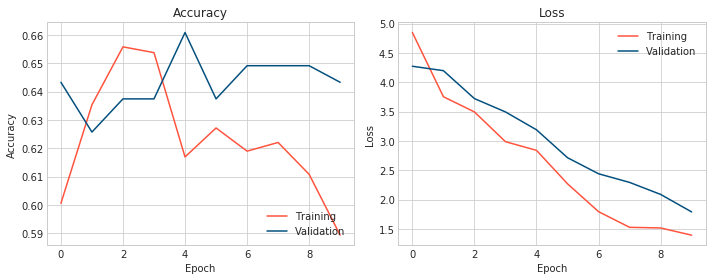

In [31]:
# Winner
plot_metrics(ft_history,stop=10)   # sgd with lr = 0.0001, sotfmax, without Regularization

In [102]:
ft_model = load_model(fine_tuned_model_path)

In [44]:
with open(location+'/top_history.txt') as f:    
    top_history = json.load(f)

Best Model: 
epoch: 35 , val_acc: 0.6842105271872024 , val_loss: 4.819097446419343


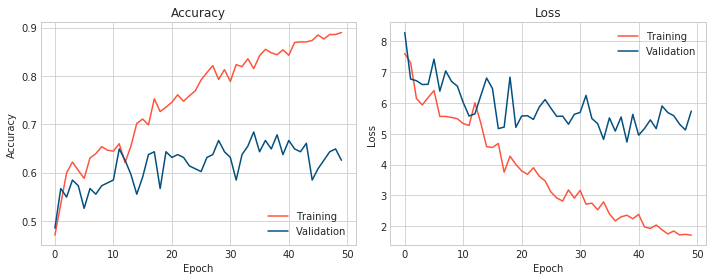

In [45]:
plot_metrics(top_history)

In [33]:
with open(location+'/ft_history.txt') as f:    
    ft_history = json.load(f)

In [43]:
val_labels = np.array([0] * val_samples[0] + 
                      [1] * val_samples[1] +
                      [2] * val_samples[2])
val_labels = to_categorical(val_labels)

In [69]:
cm = evaluate_categorical_model(ft_model, val_data_dir, np.argmax(val_labels,axis=1),Force=True)

Found 171 images belonging to 3 classes.
22/21 [==============================] - 240s 11s/step
Saving ./car-damage-dataset/data3a/pred_labels.npy

             precision    recall  f1-score   support

          0       0.81      0.62      0.70        55
          1       0.51      0.50      0.51        48
          2       0.71      0.85      0.77        68

avg / total       0.68      0.68      0.67       171




In [35]:
def plot_acc_metrics(hist1, hist2, stop1=50,stop2=10):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop1), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop1), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop2), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop2), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout()

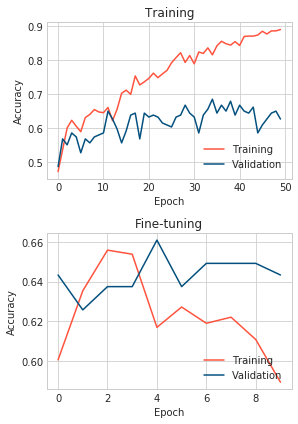

In [38]:
plot_acc_metrics(top_history, ft_history)

In [40]:
heatmap_labels = ['Minor', 'Moderate', 'Severe']

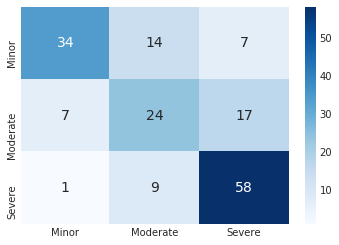

In [70]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

In [99]:
def get_edge_cases(model, directory, exp_result, false_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 256, 256)
        pred = model.predict(x)
        pred_label = np.argmax(pred, axis=1)
        if pred_label[0] == false_result:
            edge_list.append(name)
    return edge_list

In [100]:
def severity_estimator(image_path, model):
    print("Determining severity of damage...")
    urllib.request.urlretrieve(image_path, 'save_4th_gate.jpg') # or other way to upload image
    img = load_img('save_4th_gate.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    pred_label = np.argmax(pred, axis=1)
#     print(pred_label)
    d = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for key in d.keys():
        if pred_label[0] == key:
            print("Assessment: {} damage to vehicle".format(d[key]))
    print("Severity assessment complete.")

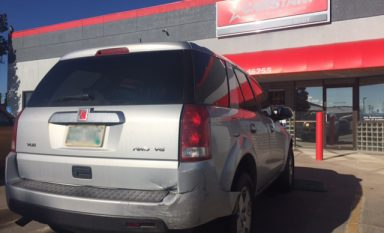

In [103]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [104]:
severity_estimator('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

Determining severity of damage...
Assessment: Minor damage to vehicle
Severity assessment complete.


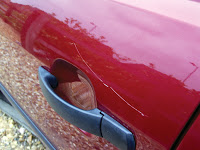

In [105]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [106]:
severity_estimator('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

Determining severity of damage...
Assessment: Minor damage to vehicle
Severity assessment complete.


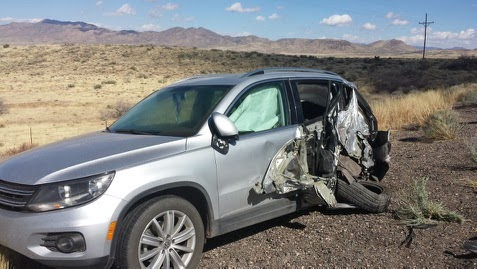

In [107]:
Image('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg')

In [108]:
severity_estimator('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg', ft_model)

Determining severity of damage...
Assessment: Severe damage to vehicle
Severity assessment complete.


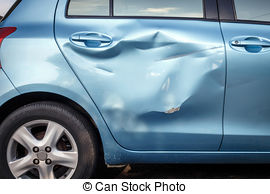

In [109]:
Image('http://cdn.xl.thumbs.canstockphoto.com/canstock23892567.jpg')

In [110]:
severity_estimator('http://cdn.xl.thumbs.canstockphoto.com/canstock23892567.jpg', ft_model)

Determining severity of damage...
Assessment: Minor damage to vehicle
Severity assessment complete.
